# Tuning with K fold cross validation

In [1]:
with_storage = False

In [2]:
import optuna

/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KDTree, BallTree
import pandas as pd
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)


class DBOCSVM:
    def __init__(
        self,
        kernel="rbf",
        degree=3,
        gamma="scale",
        coef0=0.0,
        tol=0.001,
        nu=0.5,
        shrinking=True,
        cache_size=200,
        verbose=False,
        max_iter=-1,
        eps=0.5,
        min_samples=10,
        tree_metric="euclidean",
        dbscan_metric="euclidean",
        algorithm="kd_tree",  # or 'ball_tree'
        leaf_size=30,
        n_jobs=-1,  # Add n_jobs parameter
    ):
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.nu = nu
        self.shrinking = shrinking
        self.cache_size = cache_size
        self.verbose = verbose
        self.max_iter = max_iter
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.tree_metric = tree_metric
        self.dbscan_metric = dbscan_metric
        self.dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, n_jobs=n_jobs, metric=dbscan_metric
        )  # Make it so that it can accept a metric parameter
        self.svms = {}  # One SVM per cluster
        self.dbscan_centroids = {}  # To store cluster centroids
        self.cluster_points = {}  # Store points in each cluster
        self.tree = None
        # These attributes are mainly used for inspection purposes
        self.cluster_sizes = {}  # Number of points in each cluster
        self.n_jobs = n_jobs  # Store n_jobs
        self.cluster_labels = None
        self.unique_clusters = None

    def fit_cluster(
        self,
        X,
        dbscan_evaluation_metric="silhouette",
        dbscan_rerun=False,
        dbscan_rerun_trials=10,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        dbscan_evaluation_metric : str
            Metric to optimize ('silhouette', 'davies_bouldin', or 'calinski_harabasz')
        dbscan_rerun : bool
            Whether to rerun DBSCAN after fitting the model with the best parameters
        dbscan_rerun_trials : int
            Number of reruns for DBSCAN after fitting the model with the best parameters
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """
        if verbose:
            print("Fitting DBSCAN...")
        # NOTE: we use the dbscan that was initialized in the constructor
        self.cluster_labels = self.dbscan.fit_predict(X)
        if verbose:
            print("DBSCAN Fitted...")

        if dbscan_rerun:
            if verbose:
                print("Rerunning DBSCAN...")

            if dbscan_evaluation_metric == "silhouette":
                current_score = silhouette_score(X, self.cluster_labels)
            elif dbscan_evaluation_metric == "davies_bouldin":
                current_score = davies_bouldin_score(X, self.cluster_labels)
            else:  # calinski_harabasz
                current_score = calinski_harabasz_score(X, self.cluster_labels)

            for i in range(dbscan_rerun_trials):
                if verbose:
                    print(f"DBSCAN Rerun {i+1}...")
                new_cluster_labels = self.dbscan.fit_predict(X)

                if dbscan_evaluation_metric == "silhouette":
                    new_score = silhouette_score(X, new_cluster_labels)
                    if new_score > current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score
                elif dbscan_evaluation_metric == "davies_bouldin":
                    new_score = davies_bouldin_score(X, new_cluster_labels)
                    if new_score < current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score
                else:  # calinski_harabasz
                    new_score = calinski_harabasz_score(X, new_cluster_labels)
                    if new_score > current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score

        self.unique_clusters = np.unique(self.cluster_labels)

        if verbose:
            print(f"Unique Clusters: {self.unique_clusters}")

        for cluster in self.unique_clusters:
            # Store the number of points in the cluster
            # mainly for inspection purposes
            n_points = np.sum(self.cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

    def fit_ocsvm(
        self,
        X,
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """
        X = X.values if isinstance(X, pd.DataFrame) else X

        if parameter_list is None:
            raise ValueError("parameter_list cannot be None")

        if len(parameter_list) < len(self.unique_clusters) - 1:
            raise ValueError(
                "Number of parameters should be equal or greater than the number of clusters"
            )

        def filter_dict(original_dict, keys_to_keep):
            return {k: original_dict[k] for k in keys_to_keep if k in original_dict}

        if len(parameter_list) >= len(self.unique_clusters) - 1:
            cluster_count = list(self.cluster_sizes.keys())
            cluster_count.remove(-1)
            cluster_count

            parameter_list = filter_dict(parameter_list, cluster_count)

        for cluster in self.unique_clusters:

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            # Boolean masking to get points in the current cluster
            points = X[self.cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                # use parameters defined in constructor if not provided
                if parameter_list is None:
                    ocsvm = OneClassSVM(
                        kernel=self.kernel,
                        nu=self.nu,
                        gamma=self.gamma,
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                else:
                    ocsvm = OneClassSVM(
                        kernel=parameter_list[cluster]["kernel"],
                        nu=parameter_list[cluster]["nu"],
                        gamma=parameter_list[cluster]["gamma"],
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                    if verbose:
                        print(
                            f"OCSVM for cluster {cluster} uses nu: {parameter_list[cluster]['nu']}, gamma: {parameter_list[cluster]['gamma']}, kernel: {parameter_list[cluster]['kernel']}"
                        )
                ocsvm.fit(points)

                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )

    def fit(
        self,
        X,
        dbscan_evaluation_metric="silhouette",  # only used for reruns
        dbscan_rerun=False,  # only used for reruns
        dbscan_rerun_trials=10,  # only used for reruns
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        dbscan_evaluation_metric : str
            Metric to optimize ('silhouette', 'davies_bouldin', or 'calinski_harabasz')
        dbscan_rerun : bool
            Whether to rerun DBSCAN after fitting the model with the best parameters
        dbscan_rerun_trials : int
            Number of reruns for DBSCAN after fitting the model with the best parameters
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """
        if verbose:
            print("Fitting DBSCAN...")
        # NOTE: we use the dbscan that was initialized in the constructor
        cluster_labels = self.dbscan.fit_predict(X)
        if verbose:
            print("DBSCAN Fitted...")

        if dbscan_rerun:
            if verbose:
                print("Rerunning DBSCAN...")

            if dbscan_evaluation_metric == "silhouette":
                current_score = silhouette_score(X, cluster_labels)
            elif dbscan_evaluation_metric == "davies_bouldin":
                current_score = davies_bouldin_score(X, cluster_labels)
            else:  # calinski_harabasz
                current_score = calinski_harabasz_score(X, cluster_labels)

            for i in range(dbscan_rerun_trials):
                if verbose:
                    print(f"DBSCAN Rerun {i+1}...")

                new_cluster_labels = self.dbscan.fit_predict(X)

                if dbscan_evaluation_metric == "silhouette":
                    new_score = silhouette_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                elif dbscan_evaluation_metric == "davies_bouldin":
                    new_score = davies_bouldin_score(X, new_cluster_labels)
                    if new_score < current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                else:  # calinski_harabasz
                    new_score = calinski_harabasz_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score

        unique_clusters = np.unique(cluster_labels)

        if verbose:
            print(f"Unique Clusters: {unique_clusters}")

        for cluster in unique_clusters:
            # Store the number of points in the cluster
            # mainly for inspection purposes
            n_points = np.sum(cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

        if parameter_list is not None and (len(parameter_list)) < (
            len(unique_clusters) - 1
        ):
            raise ValueError(
                "Number of parameters should be equal or greater than the number of clusters"
            )

        def filter_dict(original_dict, keys_to_keep):
            return {k: original_dict[k] for k in keys_to_keep if k in original_dict}

        if parameter_list is not None and (len(parameter_list)) >= (
            len(unique_clusters) - 1
        ):
            cluster_count = list(self.cluster_sizes.keys())
            cluster_count.remove(-1)
            cluster_count

            parameter_list = filter_dict(parameter_list, cluster_count)

        self.parameter_list = parameter_list

        for cluster in unique_clusters:

            # Store the number of points in the cluster
            # n_points = np.sum(cluster_labels == cluster)
            # self.cluster_sizes[int(cluster)] = int(n_points)

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            # Boolean masking to get points in the current cluster
            points = X[cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                # use parameters defined in constructor if not provided
                if parameter_list is None:
                    ocsvm = OneClassSVM(
                        kernel=self.kernel,
                        nu=self.nu,
                        gamma=self.gamma,
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                else:
                    ocsvm = OneClassSVM(
                        kernel=parameter_list[cluster]["kernel"],
                        nu=parameter_list[cluster]["nu"],
                        gamma=parameter_list[cluster]["gamma"],
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                    if verbose:
                        print(
                            f"OCSVM for cluster {cluster} uses nu: {parameter_list[cluster]['nu']}, gamma: {parameter_list[cluster]['gamma']}, kernel: {parameter_list[cluster]['kernel']}"
                        )
                ocsvm.fit(points)

                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )

    def predict(self, X):
        predictions = np.ones(len(X))
        X = X.values if isinstance(X, pd.DataFrame) else X

        if self.tree is None:
            return -1 * np.ones(len(X))

        # Find nearest centroid
        dist, ind = self.tree.query(X, k=1)
        nearest_clusters = [self.valid_clusters[i] for i in ind.flatten()]

        for i, cluster in enumerate(nearest_clusters):
            if cluster in self.svms:
                predictions[i] = self.svms[cluster].predict([X[i]])[0]
            else:
                predictions[i] = -1  # Anomaly if no SVM for cluster

        return predictions


"""
Classification Report on NSL-KDD:
              precision    recall  f1-score   support

     Anomaly       0.57      1.00      0.73     12832
      Normal       1.00      0.00      0.00      9711

    accuracy                           0.57     22543
   macro avg       0.78      0.50      0.36     22543
weighted avg       0.75      0.57      0.41     22543

Precision: 0.5693495429940545
Recall: 1.0
F1 Score: 0.7255866553576478
"""

"""
Tuning on the validation set results in extreme overfitting
Model performs better but only on the validation set, the test set results are worse
Cannot use the full train set since it crashed the kernel
TODO: Implement a better tuning strategy that generalizes well
TODO: Explore other preprocessing steps e.g Autoencoder, Min-Max Normalization, Feature Selection
"""

'\nTuning on the validation set results in extreme overfitting\nModel performs better but only on the validation set, the test set results are worse\nCannot use the full train set since it crashed the kernel\nTODO: Implement a better tuning strategy that generalizes well\nTODO: Explore other preprocessing steps e.g Autoencoder, Min-Max Normalization, Feature Selection\n'

# Tuning

In [4]:
import pandas as pd

### Train set

In [5]:
train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_unsplit.csv"
)
train_set = pd.read_csv(train_set_path)
train_set = train_set.sample(frac=0.1, random_state=42).reset_index(drop=True)
# fraction of 0.6 with 7 folds
print(train_set.shape)
train_set.head(10)

(12597, 125)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,1.616969,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
1,-0.11025,-0.007761,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,nmap,Probe
2,-0.11025,-0.007721,-0.004856,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
3,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
4,-0.11025,-0.007761,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,nmap,Probe
5,-0.11025,-0.007724,-0.004716,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
6,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,1.616969,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
7,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
8,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
9,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS


In [6]:
X = train_set.drop(["attack_binary", "attack_categorical", "attack_class"], axis=1)
y = train_set["attack_binary"]

In [7]:
X.head(3)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,1.616969,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432
1,-0.11025,-0.007761,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
2,-0.11025,-0.007721,-0.004856,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


In [8]:
y.head(3)

0   -1
1   -1
2    1
Name: attack_binary, dtype: int64

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


def objective(trial):
    parameter_list = {}
    for cluster in range(0, 20):
        hyperparameter = {
            "kernel": "rbf",
            "gamma": trial.suggest_float(f"gamma_{cluster}", 1e-4, 1.0, log=True),
            "nu": trial.suggest_float(f"nu_{cluster}", 0.01, 0.5),
        }
        parameter_list[cluster] = hyperparameter

    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_normal = X_train[y_train == 1]

        # if len(X_train_normal) > 31500:
        #     X_train_normal = X_train_normal.sample(n=32000, random_state=42)

        dbocsvm = DBOCSVM(
            kernel="rbf",
            gamma="auto",
            nu=0.2,
            eps=19.849059093092972,
            min_samples=47,
            algorithm="ball_tree",
        )

        dbocsvm.fit(X_train_normal.values, parameter_list=parameter_list)

        y_pred = dbocsvm.predict(X_val.values)

        # Calculate F1 score for this fold
        score = f1_score(y_val, y_pred, pos_label=-1)
        scores.append(score)

    # Return mean F1 score across all folds
    return np.mean(scores)

In [10]:
storage_path = "sqlite:///optuna_storage/study_proposed_03.db"
trials = 5

if with_storage:
    study = optuna.create_study(
        direction="maximize",
        storage=storage_path,
        study_name="study_proposed_03",
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=trials)
else:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials)

[I 2025-02-28 15:57:43,315] A new study created in memory with name: no-name-eb69ad72-feea-46ca-a71c-6b1f23332c5e
[I 2025-02-28 15:57:56,640] Trial 0 finished with value: 0.810677023233584 and parameters: {'gamma_0': 0.0008735327557780548, 'nu_0': 0.3803452684804521, 'gamma_1': 0.7056205243340135, 'nu_1': 0.037205649854287606, 'gamma_2': 0.013393214628751492, 'nu_2': 0.4026829038426118, 'gamma_3': 0.03457234580338352, 'nu_3': 0.03321275882294333, 'gamma_4': 0.0008627932391199771, 'nu_4': 0.4306328160204327, 'gamma_5': 0.000777926717566584, 'nu_5': 0.28679031409066436, 'gamma_6': 0.3101335654333413, 'nu_6': 0.2656896229004456, 'gamma_7': 0.20311164262590484, 'nu_7': 0.10230301402342254, 'gamma_8': 0.03155443054963993, 'nu_8': 0.43747864826004856, 'gamma_9': 0.6283734556099044, 'nu_9': 0.4158888186548795, 'gamma_10': 0.6077364608337151, 'nu_10': 0.15570901605074688, 'gamma_11': 0.07264170731508654, 'nu_11': 0.3920865830060676, 'gamma_12': 0.0004213946657871954, 'nu_12': 0.377900553107095

In [11]:
print(f"Best f1 score: {study.best_value:.3f}")
print(f"Best parameters: {study.best_params}")

Best f1 score: 0.844
Best parameters: {'gamma_0': 0.008459321781697317, 'nu_0': 0.07828588992570187, 'gamma_1': 0.23348683753337685, 'nu_1': 0.39490762648647354, 'gamma_2': 0.00010726436025661558, 'nu_2': 0.2659836007441519, 'gamma_3': 0.0006038184334949366, 'nu_3': 0.15412301406628828, 'gamma_4': 0.0002336373083091739, 'nu_4': 0.4859900036267549, 'gamma_5': 0.003429904431093295, 'nu_5': 0.2725976727838492, 'gamma_6': 0.000995534746295425, 'nu_6': 0.1307855455328976, 'gamma_7': 0.00549632466828859, 'nu_7': 0.08680716200627951, 'gamma_8': 0.00020767407547515133, 'nu_8': 0.31985367064046083, 'gamma_9': 0.005789283607609133, 'nu_9': 0.2730503869893182, 'gamma_10': 0.06513882554533418, 'nu_10': 0.18926725390545882, 'gamma_11': 0.003027716552438965, 'nu_11': 0.2957747646560337, 'gamma_12': 0.0028441538725428642, 'nu_12': 0.06465847736782761, 'gamma_13': 0.00019172447742354893, 'nu_13': 0.4136790943439002, 'gamma_14': 0.031550594459075855, 'nu_14': 0.17463048287924235, 'gamma_15': 0.00093816

In [12]:
parameter_list = {}

for key, value in study.best_params.items():
    cluster = key.split("_")[1]
    cluster = int(cluster)

    parameter_list[cluster] = {
        "kernel": "rbf",
        "gamma": study.best_params[f"gamma_{cluster}"],
        "nu": study.best_params[f"nu_{cluster}"],
    }

# Training with full dataset

In [13]:
train_set_full_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
train_dataset_full = pd.read_csv(train_set_full_path)
train_dataset_full = train_dataset_full.sample(frac=0.15, random_state=42).reset_index(
    drop=True
)
print(train_dataset_full.shape)
train_dataset_full.head(3)

(10101, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.11025,-0.007625,-0.004835,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
1,-0.11025,-0.007699,-0.004066,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
2,-0.11025,-0.007725,-0.004849,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


In [14]:
dbocsvm = DBOCSVM(
    kernel="rbf",
    gamma="auto",
    nu=0.2,
    eps=19.849059093092972,
    min_samples=47,
    algorithm="ball_tree",
)
print(dbocsvm.n_jobs)
dbocsvm.fit(train_dataset_full.values, parameter_list=parameter_list, verbose=True)

-1
Fitting DBSCAN...
DBSCAN Fitted...
Unique Clusters: [-1  0]
Cluster Sizes: {-1: 188, 0: 9913}
Training for cluster 0 with 9913 points
OCSVM for cluster 0 uses nu: 0.07828588992570187, gamma: 0.008459321781697317, kernel: rbf


# Testing

Preparing test set

In [15]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")

test set count: 22,543


In [16]:
test_set.head(3)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
1,-0.109482,-0.005551,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
2,-0.110250,-0.007759,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,saint,Probe


In [17]:
X_test = test_set.drop(columns=["attack_binary", "attack_categorical", "attack_class"])

y_test = test_set["attack_binary"]
y_test_class = test_set["attack_class"]
print(y_test.unique())

[-1  1]


Perform prediction

In [18]:
y_pred = dbocsvm.predict(X_test.values)

In [19]:
print(*y_pred[:10], sep="\n")

-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0


In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10878  1954]
 [ 1007  8704]]


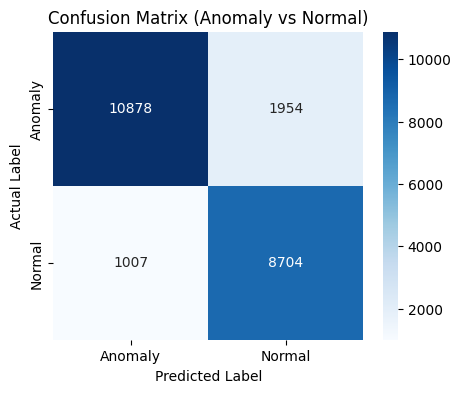

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [22]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.92      0.85      0.88     12832
      Normal       0.82      0.90      0.85      9711

    accuracy                           0.87     22543
   macro avg       0.87      0.87      0.87     22543
weighted avg       0.87      0.87      0.87     22543

Precision: 0.9152713504417332
Recall: 0.8477244389027432
F1 Score: 0.8802039082412915
Accuracy: 0.8686510224903518


In [23]:
import json
import datetime

log_file = "/home/jbct/Projects/thesis/db-ocsvm/test.log.json"

if acc > 0.84:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    performance = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc,
    }
    data_to_save = {
        "timestamp": timestamp,
        "parameters": dbocsvm.parameter_list,
        "performance": performance,
    }

    try:
        with open(log_file, "r") as f:
            existing_data = json.load(f)

        existing_data.append(data_to_save)
    except json.JSONDecodeError:
        existing_data = [data_to_save]

    with open(log_file, "w") as f:
        json.dump(existing_data, f, indent=4)

    print("Parameters saved to log file")
else:
    print("Parameters not saved to log file")
    print("Acc is below 0.85")

Parameters saved to log file


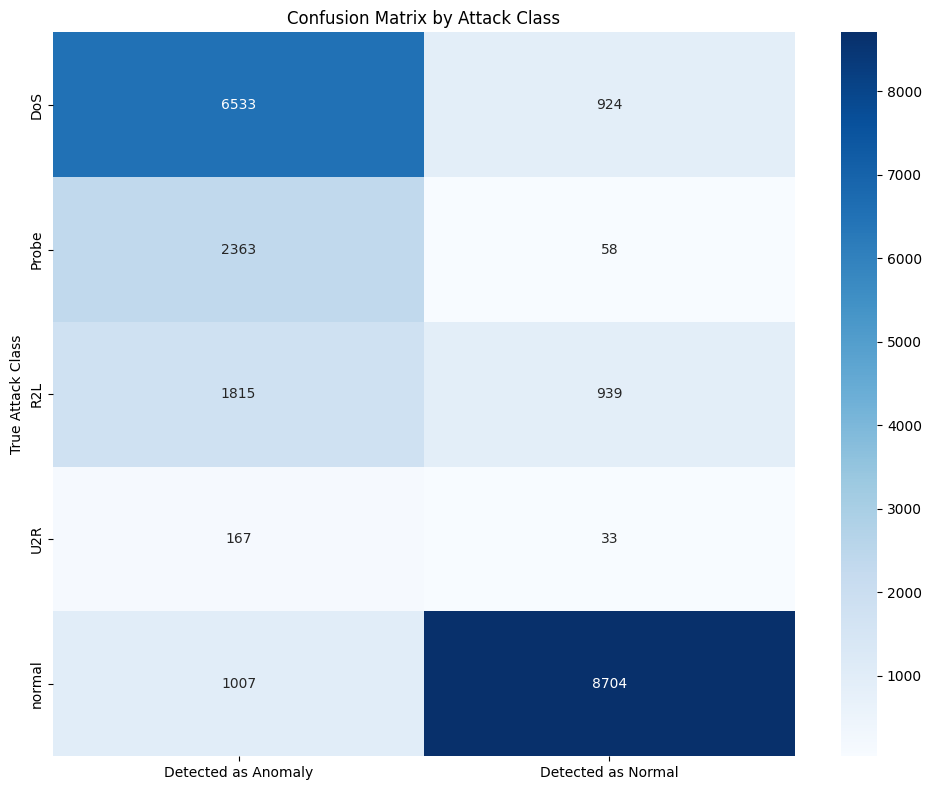

In [24]:
def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
DoS: 0.8761 (6533/7457)
Probe: 0.9760 (2363/2421)
R2L: 0.6590 (1815/2754)
U2R: 0.8350 (167/200)
normal: 0.1037 (1007/9711)


: 